<center>
<a href="https://colab.research.google.com/drive/1QaoSKUbLy4ViHnJsl3m3H6xEemDdowkL?usp=sharing"> <img align="center" src="https://colab.research.google.com/assets/colab-badge.svg"> </a></center>

## Installing Packages

Run this cell only if torchtext reports an error while importing bleu_score.

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 1.1MB 7.0MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


##Importing Required Libraries




In [ ]:
from google.colab import drive
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import numpy as np
import random
import spacy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [ ]:
SEED = 4444

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Fetching Spacy Models

In [ ]:
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 3.8MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=5c3dff1402589b3c1bbda21067a1ccf92b1d799398efe9e444dc388c9b746046
  Stored in directory: /tmp/pip-ephem-wheel-cache-ug_l73zp/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Helper Objects and Functions

In [ ]:
de_model = spacy.load('de')
en_model = spacy.load('en')

Unlike the paper, reversing the input sequence resulted in a lower BLEU Score. Hence, the input sequences have not been reversed. 

In [ ]:
def de_tokenizer(sentence):
    return [token.text for token in de_model.tokenizer(sentence)]

def en_tokenizer(sentence):
    return [token.text for token in en_model.tokenizer(sentence)]

In [ ]:
SOURCE_Field = Field(eos_token = '<src_eos>', init_token = '<src_sos>', lower = True, tokenize = de_tokenizer)

TARGET_Field = Field(eos_token = '<trg_eos>', init_token = '<trg_sos>', lower = True, tokenize = en_tokenizer)

A helper function to return an input tensor corresponding to any string or list of tokens.

In [ ]:
def ipTensor(sentence, src_field):
    if isinstance(sentence, list):
        tokens = [src_field.init_token] + [token.lower() for token in sentence] + [src_field.eos_token]
    else:
        tokens = [src_field.init_token] + de_tokenizer(sentence) + [src_field.eos_token]
    seq_len = len(tokens)
    ip_tensor = torch.LongTensor([src_field.vocab.stoi[token] for token in tokens]).to(device)
    return ip_tensor.view(seq_len, 1)

## Fetching and Splitting Data

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SOURCE_Field, TARGET_Field))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 926kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 246kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 236kB/s]


In [ ]:
SOURCE_Field.build_vocab(train_data, min_freq = 2)
TARGET_Field.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Source vocab size: {len(SOURCE_Field.vocab)} | Target vocab size: {len(TARGET_Field.vocab)}")

Source vocab size: 7855 | Target vocab size: 5893


## Model Definition

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, enc_dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=enc_dropout)
        self.dropout = nn.Dropout(enc_dropout)

    def forward(self, input):
        embedding = self.dropout(self.embedding(input))                         # input = [seq_len, batch_size]  embedding = [seq_len, batch_size, embedding_dim]
        output, states = self.rnn(embedding)                                    # output = [seq_len, batch_size, num_directions*hidden_dim]   **Here number of directions is 1
                                                                                # states = (hidden, cell) = [num_layers*num_directions, batch_size, hidden_dim]
        return states

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dec_dropout):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, dropout=dec_dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dec_dropout)

    def forward(self, input, states):
        embedding = self.dropout(self.embedding(input))                         # input = [1, batch_size]  embedding = [1, batch_size, embedding_dim]
        output, states = self.rnn(embedding, states)                            # output = [seq_len, batch_size, num_directions*hidden_dim]   **Here number of directions is 1
        output = self.fc(output).unsqueeze(0)                                   # output = [seq_len, batch_size, vocab_size]

        return output, states

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, source, target, teacher_forcing_ratio):
        enc_states = self.encoder(source)                                       # source = [seq_len, batch_size]  target = [seq_len, batch_size]
        dec_states = enc_states                                                 
        seq_len = target.shape[0]
        batch_size = target.shape[1]
        predictions = torch.zeros(seq_len, batch_size, self.decoder.output_dim).to(device)
        input = target[0,:].unsqueeze(0)                                        # input = [1, batch_size]
        for t in range(1, seq_len):
            output, dec_states = self.decoder(input, dec_states) 
            output = output.squeeze()               
            predictions[t] = output.view(batch_size, self.decoder.output_dim)
            if random.random() < teacher_forcing_ratio:
                input = target[t].unsqueeze(0)
            else:
                input = output.argmax(1).unsqueeze(0)

        return predictions[1:]

## Training and Evaluation Functions

```teacher_forcing_ratio``` is the probability of using the ground truth tokens as inputs while decoding. It is usually set to 1 while training and 0 while sampling. However, setting it to 0.5 resulted in a better BLEU Score than setting it to 1.


In [ ]:
def Train(iterator, model, criterion, optimizer, clip=1):
    model.train()
    epoch_loss = 0
    for _, batch in enumerate(iterator):
        model.zero_grad()
        source = batch.src
        target = batch.trg
        outputs = model(source, target, teacher_forcing_ratio=0.5)
        outputs = outputs.view(-1, outputs.shape[-1])
        targets = target[1:].view(-1)
        batch_loss = criterion(outputs, targets.to(device))
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += batch_loss.item()

    return epoch_loss/len(iterator)

In [ ]:
def Evaluate(iterator, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            model.zero_grad()
            source = batch.src
            target = batch.trg
            outputs = model(source, target, 0)
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = target[1:].view(-1)
            batch_loss = criterion(outputs, targets.to(device))
            eval_loss += batch_loss.item()
        
        return eval_loss/len(iterator)

In [ ]:
def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return (elapsed_mins, elapsed_secs)

## Data Iterators, Hyperparameters and Model Initialization

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [ ]:
print("Number of Training sequences: ", len(train_data.examples))
print("Number of Test sequences: ", len(test_data.examples))
print("Number of Validation sequences: ", len(valid_data.examples))

Number of Training sequences:  29000
Number of Test sequences:  1000
Number of Validation sequences:  1014


In [ ]:
CLIP = 1
NUM_EPOCHS = 20
LR = 0.001
HIDDEN_DIM = 512
SRC_VOCAB_SIZE = len(SOURCE_Field.vocab)
TRG_VOCAB_SIZE = len(TARGET_Field.vocab)
EMBEDDING_DIM = 256
NUM_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
target_padding_index = TARGET_Field.vocab.stoi[TARGET_Field.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = target_padding_index)

In [ ]:
encoder = Encoder(SRC_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, ENC_DROPOUT).to(device)
decoder = Decoder(TRG_VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, DEC_DROPOUT).to(device)
seq2seq = Seq2Seq(encoder, decoder).to(device)
optimizer = optim.AdamW(seq2seq.parameters(), LR)

In [ ]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [ ]:
seq2seq.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters.')

The model has 13,899,013 trainable parameters.


## Download Pre-Trained Model
Run this section instead of the "Training" section if you wish to download the pre-trained model instead of training one yourself.

In [ ]:
# !wget -O Seq2Seq.pth https://gitlab.com/rishika2110/weights/-/blob/6e88f0c7acaf5d86d803eca8abb150e0b79f95ef/neural_machine_translation/Seq2Seq.pth

In [ ]:
# MODEL_STORE_PATH = "Seq2Seq.pth"

## Training
Run this section only if you want to train the model yourself and store the trained weights in G-Drive.

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
MODEL_STORE_PATH = "/content/gdrive/My Drive/Colab/NLP/Machine Translation/Models/Seq2Seq.pth"

In [ ]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
prev_epoch = 1
min_losses = [float('inf'), float('inf')]
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = Train(train_iterator, seq2seq, criterion, optimizer, CLIP)
    train_losses.append(train_loss)
    valid_loss = Evaluate(test_iterator, seq2seq, criterion)
    valid_losses.append(valid_loss)
    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(seq2seq.state_dict(), MODEL_STORE_PATH)
    if epoch % int(NUM_EPOCHS / 10) == 0:
        elapsed_time = Epoch_time(start_time, time.time())
        print(f"Time taken for epochs {prev_epoch} to {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
        start_time = time.time()
        prev_epoch = epoch + 1
        print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
        print(f"Training PPL: {math.exp(train_loss):.4f} | Validation PPL: {math.exp(valid_loss):.4f}")
print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 512
Time taken for epochs 1 to 2: 0m 58s
Training Loss: 4.4550 | Validation Loss: 4.8925
Training PPL: 86.0585 | Validation PPL: 133.2917
Time taken for epochs 3 to 4: 0m 57s
Training Loss: 3.8824 | Validation Loss: 4.4057
Training PPL: 48.5411 | Validation PPL: 81.9133
Time taken for epochs 5 to 6: 0m 57s
Training Loss: 3.5491 | Validation Loss: 4.0467
Training PPL: 34.7832 | Validation PPL: 57.2102
Time taken for epochs 7 to 8: 0m 56s
Training Loss: 3.2654 | Validation Loss: 3.8067
Training PPL: 26.1910 | Validation PPL: 45.0001
Time taken for epochs 9 to 10: 0m 57s
Training Loss: 2.9953 | Validation Loss: 3.7599
Training PPL: 19.9914 | Validation PPL: 42.9428
Time taken for epochs 11 to 12: 0m 57s
Training Loss: 2.7629 | Validation Loss: 3.7169
Training PPL: 15.8450 | Validation PPL: 41.1354
Time taken for epochs 13 to 14: 0m 56s
Training Loss: 2.5728 | Validation Loss: 3.6241
Training PPL: 13.1024 | Validation PPL: 37.4899
Time taken for epo

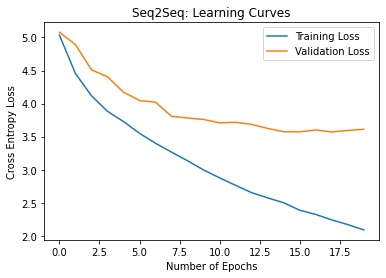

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Seq2Seq: Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()
plt.savefig("/content/gdrive/My Drive/Colab/NLP/Machine Translation/Plots/Seq2Seq.jpeg")

## Sampling

Run the cell below to load the model for sampling.


In [ ]:
seq2seq.load_state_dict(torch.load(MODEL_STORE_PATH))

<All keys matched successfully>

In [ ]:
seq2seq.eval()
test_loss = Evaluate(test_iterator, seq2seq, criterion)
print(f"Test Loss: {test_loss:.4f} | Test PPL: {math.exp(test_loss):.4f}")

Test Loss: 3.5708 | Test PPL: 35.5440


In [ ]:
def Translate(src_sentence, src_field, trg_field, model):
    ip_tensor = ipTensor(src_sentence, src_field)
    max_len = 4*ip_tensor.shape[0]
    src_len = [ip_tensor.shape[0]]
    with torch.no_grad():
        enc_states = model.encoder(ip_tensor)
    dec_states = enc_states
    sos_id = trg_field.vocab.stoi[trg_field.init_token]
    eos_id = trg_field.vocab.stoi[trg_field.eos_token]
    predicts = [sos_id]
    len = 1
    while len < max_len:
        input = torch.LongTensor([predicts[-1]]).view((1, 1)).to(device)
        with torch.no_grad():
            output, dec_states = model.decoder(input, dec_states)
        output = output.squeeze()
        output = output.view(-1, model.decoder.output_dim)
        predicts.append(output.argmax(-1).item())
        len += 1
        if predicts[-1] == eos_id:
            break
    sentence = [trg_field.vocab.itos[id] for id in predicts[1:]]
    return sentence

In [ ]:
ind = int(random.random() * len(test_data.examples))
example = test_data.examples[ind]
src_sentence = example.src
trg_sentence = example.trg
print("German Sentence: ", ' '.join(src_sentence))
translation = Translate(src_sentence, SOURCE_Field, TARGET_Field, seq2seq)
print("Predicted Translation: ", ' '.join(translation[:-1]))
print("Actual Translation: ", ' '.join(trg_sentence))

German Sentence:  ein älterer mann sitzt in einem stuhl und isst ein paar snacks .
Predicted Translation:  an elderly man sits sitting in a chair chair while drinking .
Actual Translation:  an elderly man sitting in a chair , eating some snacks .


## BLEU Score

In [ ]:
def Calculate_BLEU(data, src_field, trg_field, model):
    trgs = []
    predicted_trgs = []
    for i in range(len(data.examples)):
        src_sentence = vars(data[i])['src']
        trg_sentence = vars(data[i])['trg']
        try:                                # Sometimes(rarely) CUDA throws a "Device side assert triggered" error. So, just to avoid restarting runtime.
            predicted_trg = Translate(src_sentence, src_field, trg_field, model)
            predicted_trgs.append(predicted_trg[:-1])
            trgs.append([trg_sentence])
        except:
            pass
    return bleu_score(predicted_trgs, trgs)

In [ ]:
bleu_score_test = Calculate_BLEU(test_data, SOURCE_Field, TARGET_Field, seq2seq)
print(f"BLEU score on Testing Data: {bleu_score_test*100:.2f}")

BLEU score on Testing Data: 20.03
